# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Risk_analytics

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [3]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [4]:
sum(rets["USA_RUB=X"] > 100)

0

In [5]:
# read the risk free rate
riskfree = pd.read_csv("3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = (1 + riskfree).pow(1/252) - 1

riskfree.head()

,RFR
Date,
2011-01-04,0.000520
2011-01-05,0.000520
2011-01-06,0.000537
2011-01-07,0.000520
2011-01-10,0.000520


In [6]:
len(riskfree.index) == len(rets.index)

True

In [7]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')
benchmark = benchmark['return']

benchmark.isnull().values.any()

False

In [8]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [9]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [10]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])
print(semiannual[1].index[0],semiannual[1].index[-1])
print(semiannual[19].index[0],semiannual[19].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00
2011-08-01 00:00:00 2012-01-31 00:00:00
2020-07-31 00:00:00 2021-01-29 00:00:00


# Lowest correlation Search

In [11]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)

# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [12]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [13]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer

from importlib import reload
reload(portfolio_optimizer)

from portfolio_optimizer import portfolio_optimizer

In [14]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':1100,'VaR99':1800,'CVaR95':2700,'CVaR99':4400}

10 cutoff ETFs

In [15]:
opt10 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'MVO', benchmark)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Equally weighted')

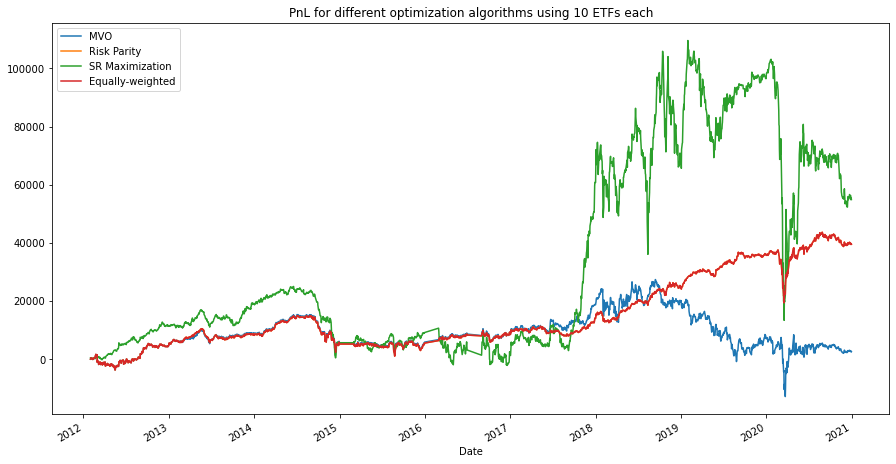

In [16]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')

plt.title('PnL for different optimization algorithms using 10 ETFs each')
plt.legend()
plt.show()

In [17]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -331.4465391578136%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.368629,-1273.524510,-1075.570021,-1520.118875
3,-592.911377,-762.659293,-710.189903,-890.404912
4,-587.252419,-888.182013,-757.418148,-947.638732
5,-477.766727,-617.249447,-557.777958,-636.323188
6,-409.478225,-470.104061,-467.416810,-551.883211
7,-1100.839661,-1644.935008,-1469.009257,-1689.452910
8,-614.533489,-953.509435,-813.712463,-1111.973404
9,-988.413499,-1661.282616,-1983.166326,-4079.240494
10,-559.738278,-903.917836,-794.658141,-1146.212585


In [18]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -331.4455009206793%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.366403,-1273.520597,-1075.567012,-1520.114222
3,-592.911100,-762.658769,-710.189476,-890.404453
4,-527.265383,-791.549183,-679.418074,-855.961967
5,-474.871534,-613.508917,-554.397744,-632.466944
6,-406.997007,-467.255425,-464.584482,-548.539027
7,-1094.168021,-1634.966932,-1460.106932,-1679.214784
8,-610.809573,-947.731668,-808.781669,-1105.235165
9,-982.424161,-1651.216246,-1971.148801,-4054.520718
10,-556.347298,-898.439433,-789.842548,-1139.266563


In [19]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -129.51057165001424%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-445.681030,-727.936039,-620.899957,-853.771656
3,-611.818420,-801.571664,-735.761465,-882.108300
4,-739.262524,-1102.216994,-944.953117,-1191.442016
5,-811.001007,-1561.264026,-1230.914280,-1713.586854
6,-692.448230,-1028.901194,-902.382998,-1137.511907
7,-1304.814385,-2303.941246,-1857.559353,-2484.026075
8,-702.135408,-1128.677512,-954.686008,-1259.004874
9,-1253.561837,-2702.022250,-1861.862832,-2928.074379
10,-1523.207301,-2009.158932,-1889.299567,-2373.506471


In [20]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -331.4465391578136%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.368629,-1273.524510,-1075.570021,-1520.118875
3,-592.911377,-762.659293,-710.189903,-890.404912
4,-527.265502,-791.549418,-679.418176,-855.962071
5,-474.871692,-613.509215,-554.398094,-632.467378
6,-406.996986,-467.255459,-464.584491,-548.539067
7,-1094.169106,-1634.967500,-1460.107774,-1679.215645
8,-610.809714,-947.731631,-808.781760,-1105.235384
9,-982.424193,-1651.216049,-1971.149300,-4054.522274
10,-556.346535,-898.440532,-789.842898,-1139.267093


Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 10 ETFs each')

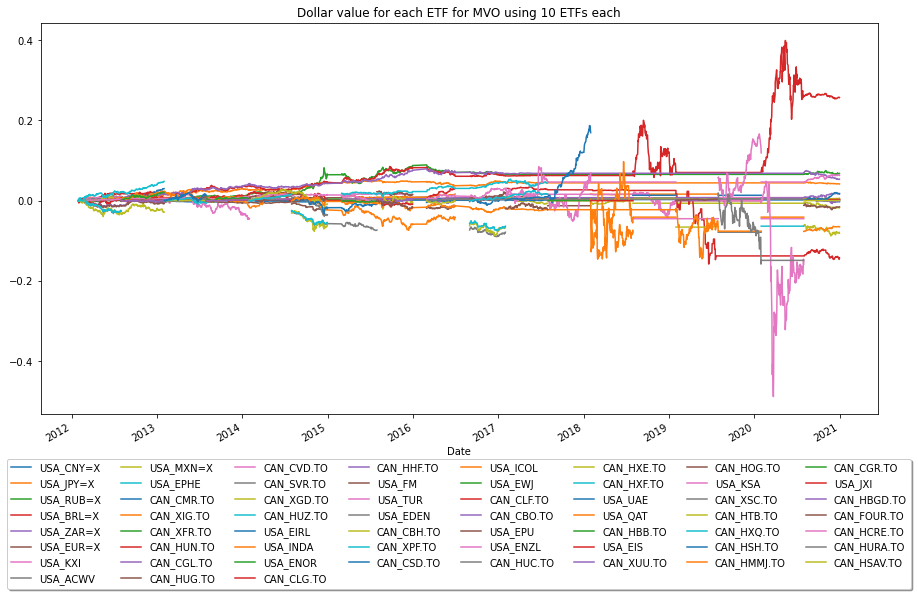

In [21]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/7))
plt.title('Dollar value for each ETF for MVO using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 10 ETFs each')

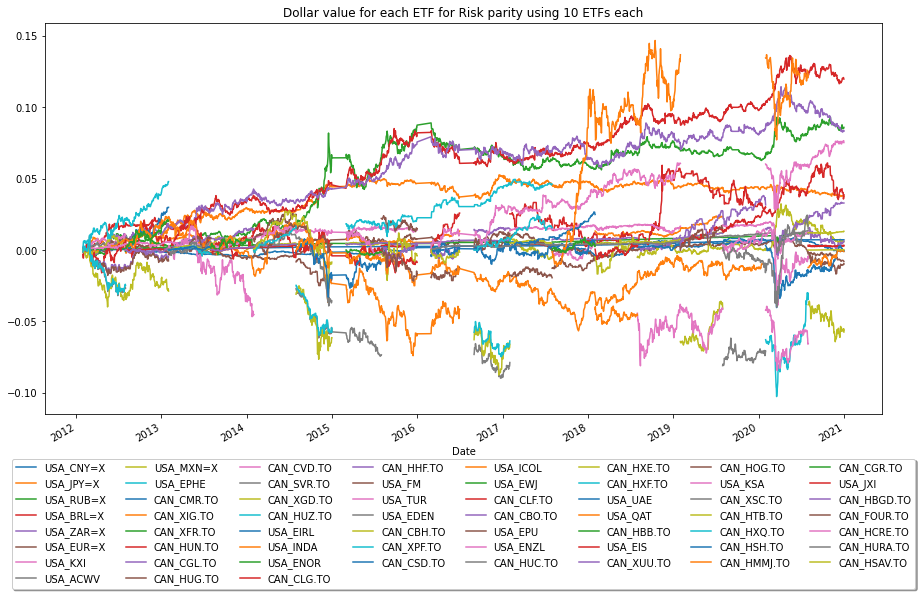

In [22]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/7))
plt.title('Dollar value for each ETF for Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 10 ETFs each')

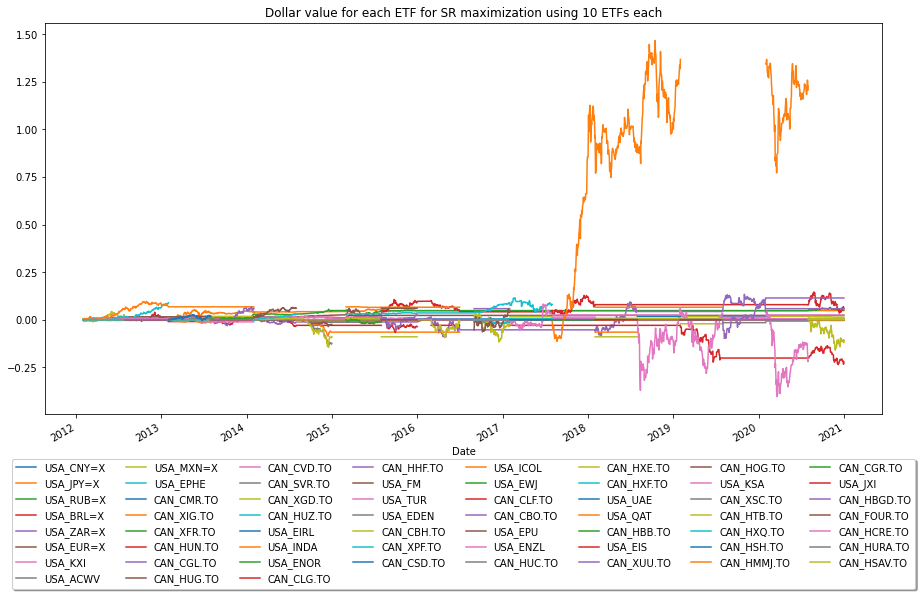

In [23]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/7))
plt.title('Dollar value for each ETF for SR maximization using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 10 ETFs each')

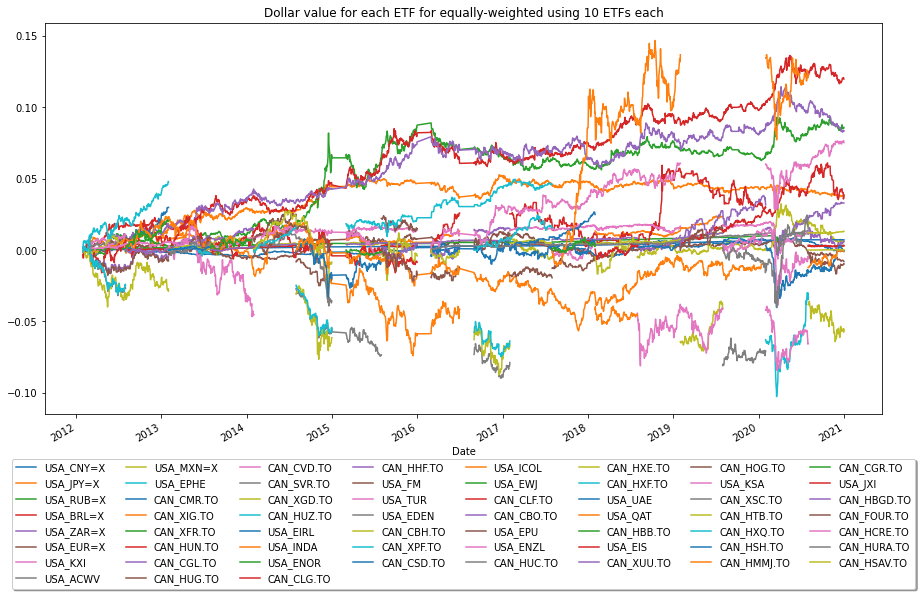

In [24]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 10 ETFs each')

15 cutoff ETFs

In [25]:
opt15 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'MVO', benchmark)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Equally weighted')

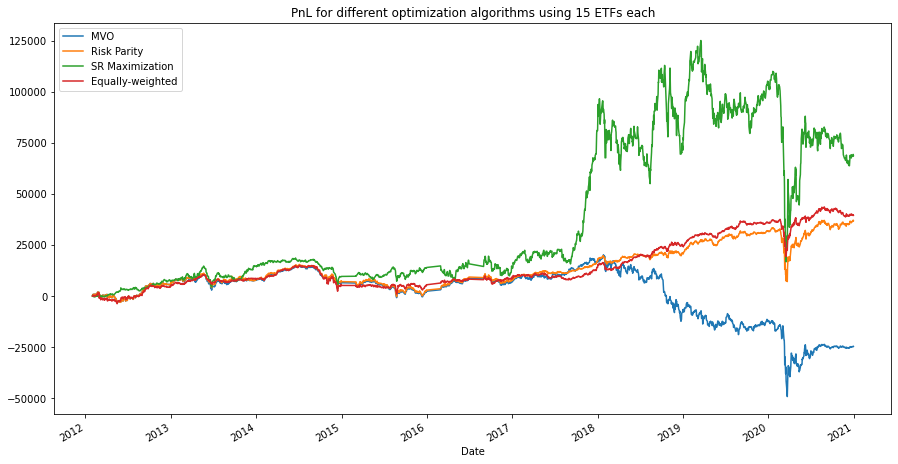

In [26]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')

plt.title('PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

In [27]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -343.8651818852504%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-840.399448,-1299.023421,-1097.031305,-1403.365446
3,-534.099509,-779.776816,-707.653139,-887.410976
4,-782.241047,-1753.004019,-1229.025299,-1880.296208
5,-520.355638,-863.100044,-718.973451,-976.515440
6,-429.224035,-513.660780,-512.276927,-668.943076
7,-955.420764,-1424.267861,-1258.950829,-1553.994645
8,-784.027481,-1132.789239,-1034.272625,-1200.134867
9,-1038.195187,-2274.074427,-1736.884180,-3306.154400
10,-788.602673,-1223.063780,-1126.480587,-1733.339917


In [28]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -257.05024090727795%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-840.395599,-1299.017198,-1097.026379,-1403.358563
3,-534.098372,-779.775845,-707.652031,-887.409688
4,-689.019001,-1524.643254,-1066.298829,-1620.179955
5,-679.153148,-1022.465194,-877.497702,-1122.298053
6,-431.862183,-516.817873,-515.425626,-673.054629
7,-961.292489,-1433.021241,-1266.688451,-1563.545447
8,-788.845643,-1139.749606,-1040.628232,-1207.509527
9,-1044.576712,-2288.052442,-1747.560265,-3326.476465
10,-793.448632,-1230.580091,-1133.403253,-1743.992680


In [29]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -271.40465571193795%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-342.789979,-466.307804,-413.694199,-512.865645
3,-464.000718,-569.430990,-557.302910,-696.482468
4,-1165.465093,-1851.655341,-1523.432317,-2136.641203
5,-765.550963,-1439.997487,-1122.248996,-1580.669185
6,-502.428227,-700.578994,-610.306993,-770.502480
7,-756.887894,-1403.695179,-1082.319567,-1465.044476
8,-548.721906,-850.689352,-709.639837,-888.970417
9,-1339.532185,-2738.745986,-1988.945822,-3124.939031
10,-1287.771596,-1743.017985,-1562.721113,-1805.096187


In [30]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -331.4465391578136%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.368629,-1273.524510,-1075.570021,-1520.118875
3,-592.911377,-762.659293,-710.189903,-890.404912
4,-527.265502,-791.549418,-679.418176,-855.962071
5,-474.871692,-613.509215,-554.398094,-632.467378
6,-406.996986,-467.255459,-464.584491,-548.539067
7,-1094.169106,-1634.967500,-1460.107774,-1679.215645
8,-610.809714,-947.731631,-808.781760,-1105.235384
9,-982.424193,-1651.216049,-1971.149300,-4054.522274
10,-556.346535,-898.440532,-789.842898,-1139.267093


Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 15 ETFs each')

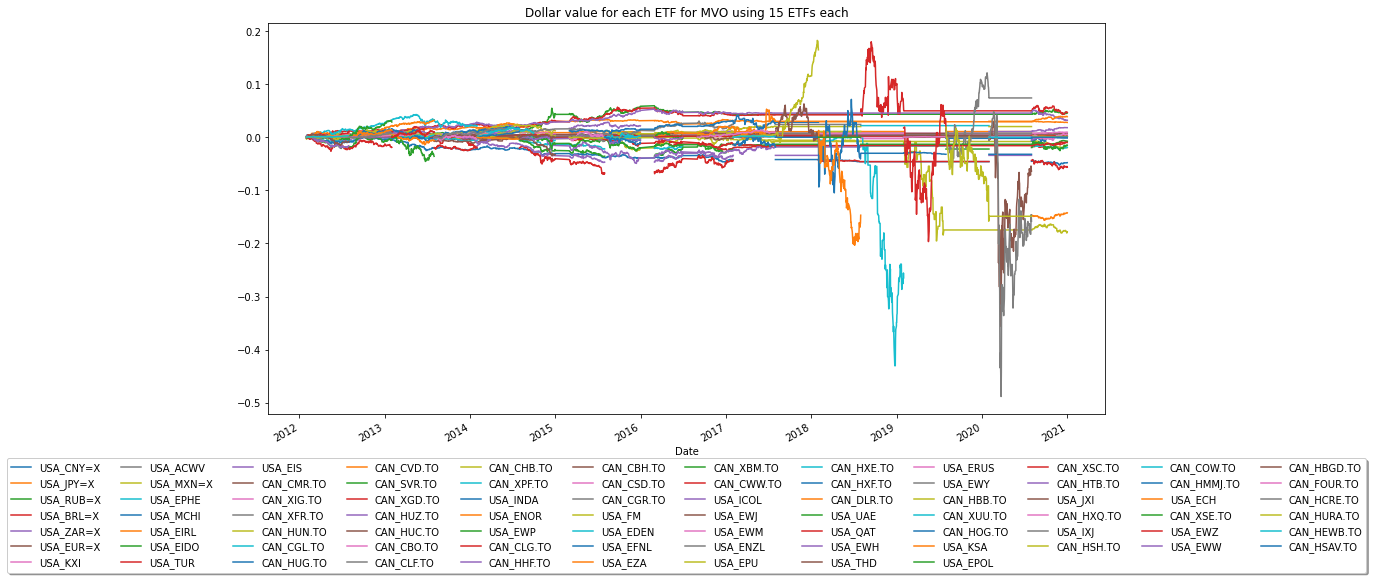

In [31]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/7))
plt.title('Dollar value for each ETF for MVO using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 15 ETFs each')

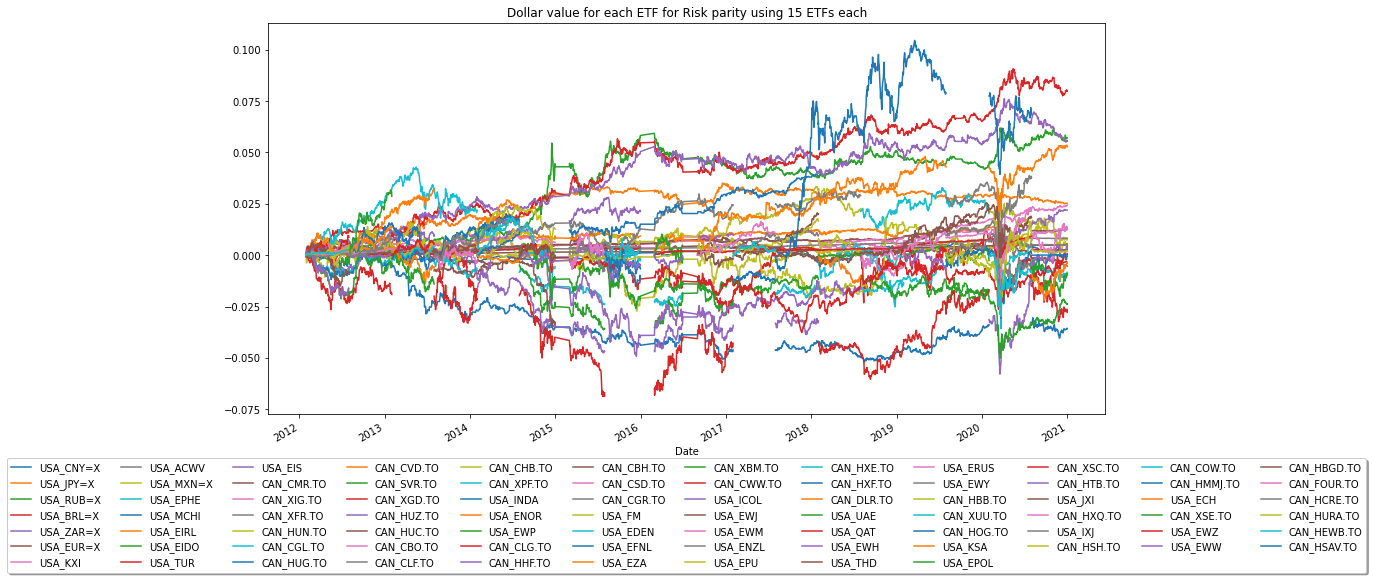

In [32]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/7))
plt.title('Dollar value for each ETF for Risk parity using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 15 ETFs each')

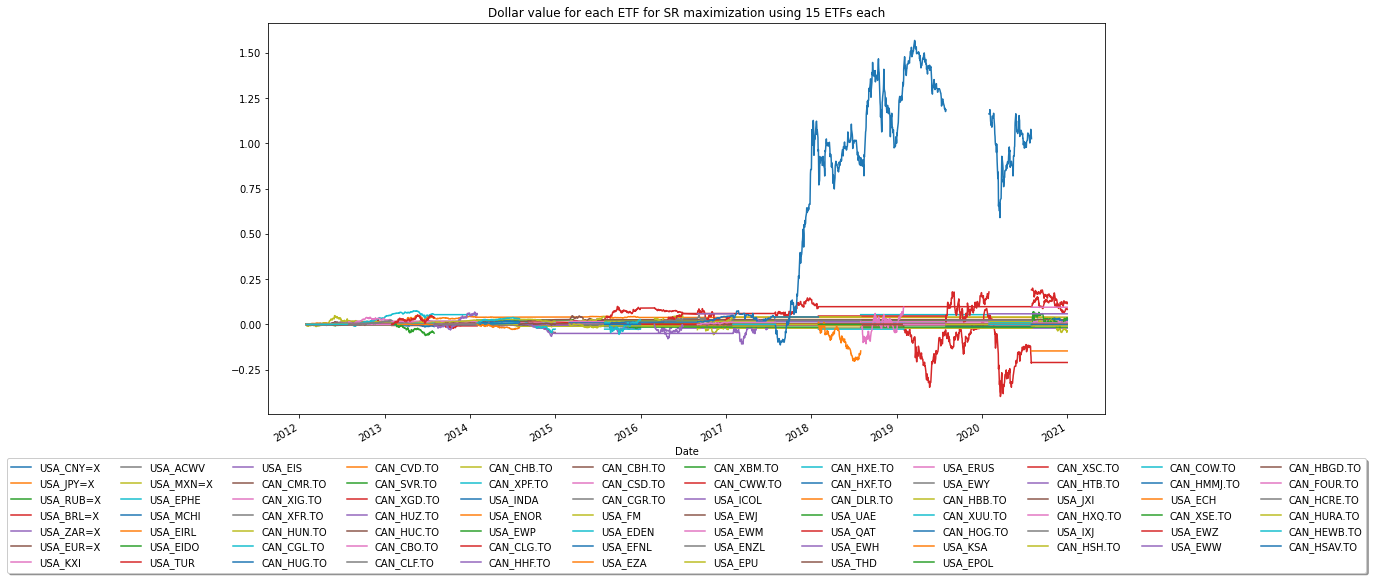

In [33]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/7))
plt.title('Dollar value for each ETF for SR maximization using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 15 ETFs each')

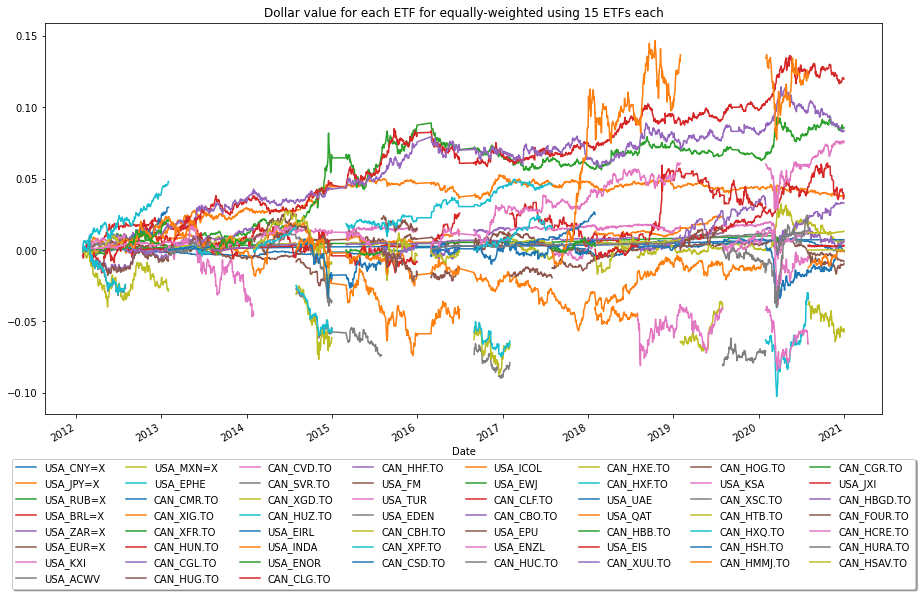

In [34]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 15 ETFs each')

30 cutoff ETFs

In [35]:
opt30 = portfolio_optimizer(semiannual)

# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'MVO', benchmark)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Sharpe ratio maximization')

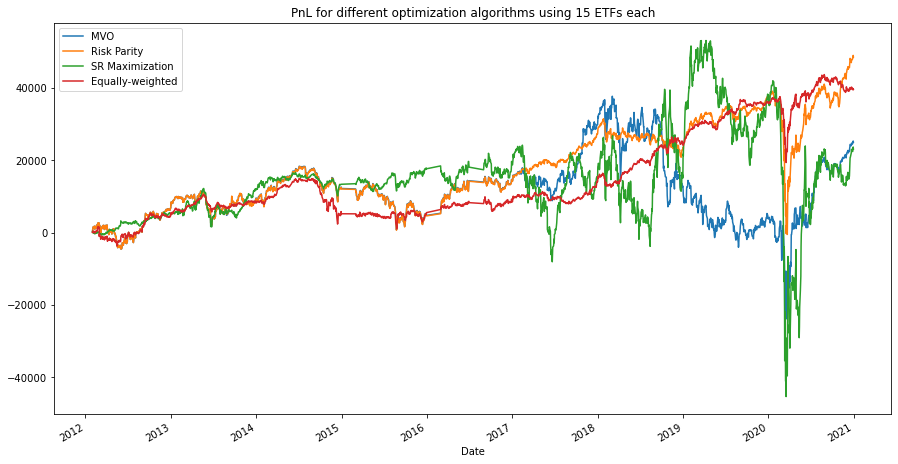

In [36]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')

plt.title('PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

In [37]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -270.9191137410651%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-968.649132,-1513.447497,-1248.037943,-1524.209876
3,-542.989381,-947.355248,-765.317089,-983.542117
4,-903.136617,-1955.871840,-1502.741812,-2399.056401
5,-988.648243,-1493.764757,-1254.542333,-1609.230016
6,-692.526419,-1124.847756,-960.849838,-1161.809590
7,-927.215724,-1220.941533,-1128.890622,-1370.385189
8,-815.582542,-1195.805934,-1043.179653,-1330.010117
9,-1175.367976,-2544.783173,-1815.084352,-2758.576454
10,-948.595457,-1641.879563,-1485.497537,-2311.278718


In [38]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -270.91688905353476%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-968.636816,-1513.433351,-1248.025918,-1524.194985
3,-542.987264,-947.352805,-765.315084,-983.539845
4,-903.135971,-1955.870225,-1502.740608,-2399.054218
5,-1022.203587,-1537.848540,-1297.492795,-1666.355063
6,-692.319319,-1124.513259,-960.563085,-1161.463571
7,-926.940841,-1220.579284,-1128.555278,-1369.977832
8,-815.339556,-1195.449689,-1042.868979,-1329.614045
9,-1175.019475,-2544.028016,-1814.546086,-2757.760425
10,-948.310034,-1641.387479,-1485.052266,-2310.587372


In [39]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -349.3128585513797%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-326.150609,-452.222801,-393.652142,-472.335097
3,-393.089726,-522.196175,-480.100597,-589.073670
4,-1247.061739,-1789.857112,-1595.295644,-2184.937379
5,-688.920866,-1117.318551,-963.412486,-1315.189813
6,-493.271006,-647.185335,-588.230045,-704.842292
7,-556.658688,-1026.499197,-788.483282,-1140.266883
8,-522.154649,-786.257165,-664.771759,-807.934146
9,-983.498866,-1287.909871,-1239.074601,-1666.403423
10,-1042.902165,-1391.737899,-1231.232963,-1456.239494


In [40]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -331.4465391578136%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.368629,-1273.524510,-1075.570021,-1520.118875
3,-592.911377,-762.659293,-710.189903,-890.404912
4,-527.265502,-791.549418,-679.418176,-855.962071
5,-474.871692,-613.509215,-554.398094,-632.467378
6,-406.996986,-467.255459,-464.584491,-548.539067
7,-1094.169106,-1634.967500,-1460.107774,-1679.215645
8,-610.809714,-947.731631,-808.781760,-1105.235384
9,-982.424193,-1651.216049,-1971.149300,-4054.522274
10,-556.346535,-898.440532,-789.842898,-1139.267093


Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 30 ETFs each')

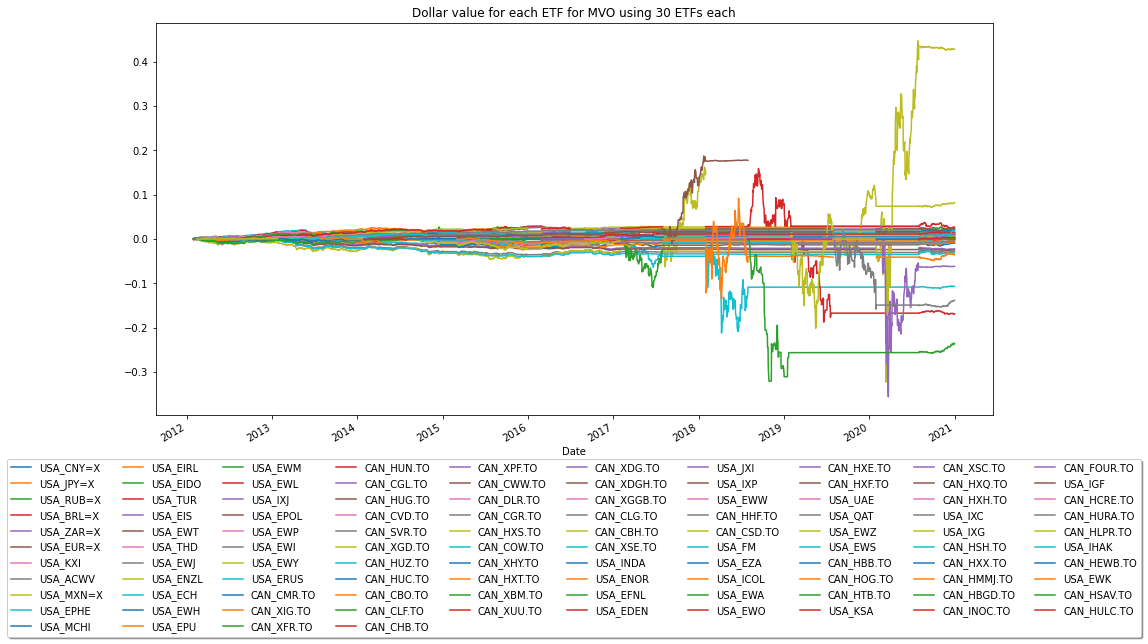

In [45]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/10))
plt.title('Dollar value for each ETF for MVO using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 30 ETFs each')

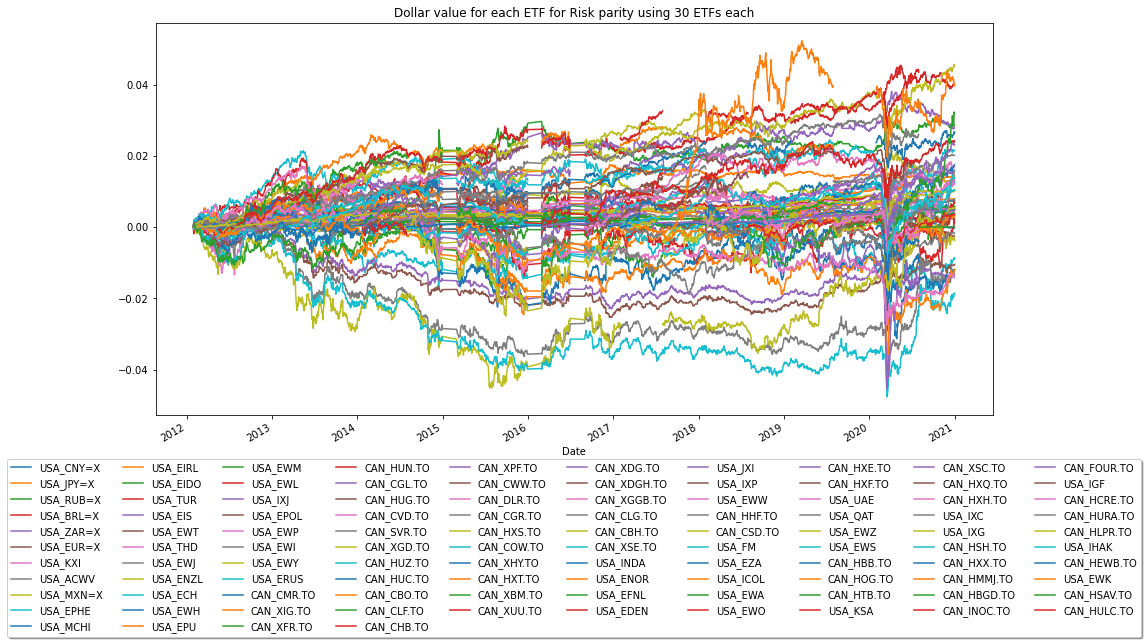

In [46]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/10))
plt.title('Dollar value for each ETF for Risk parity using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 30 ETFs each')

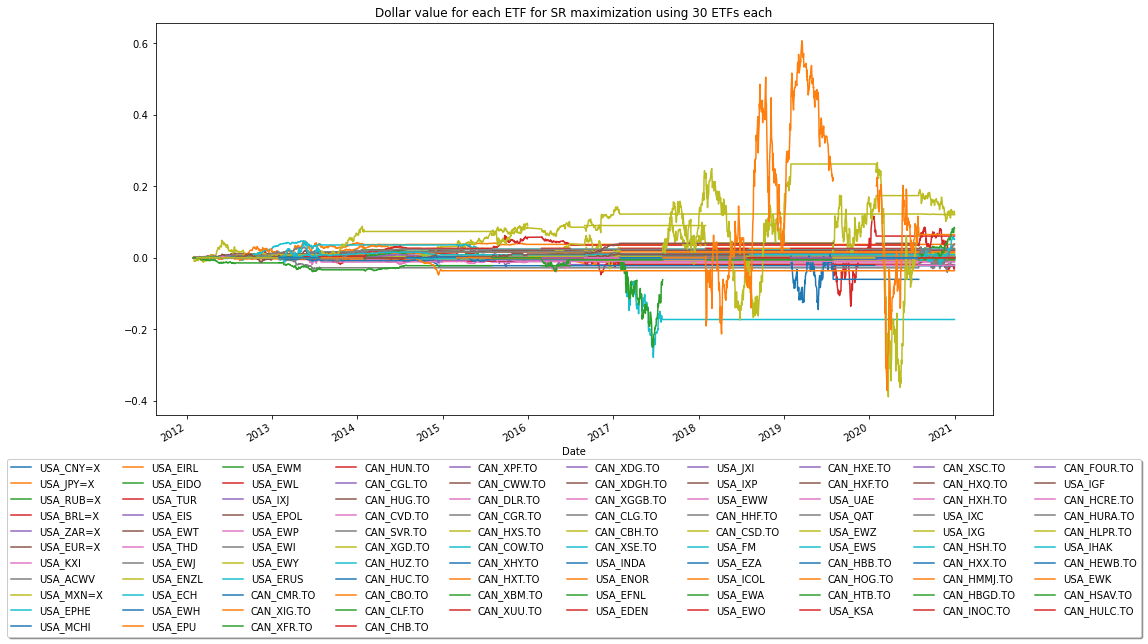

In [47]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/10))
plt.title('Dollar value for each ETF for SR maximization using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 30 ETFs each')

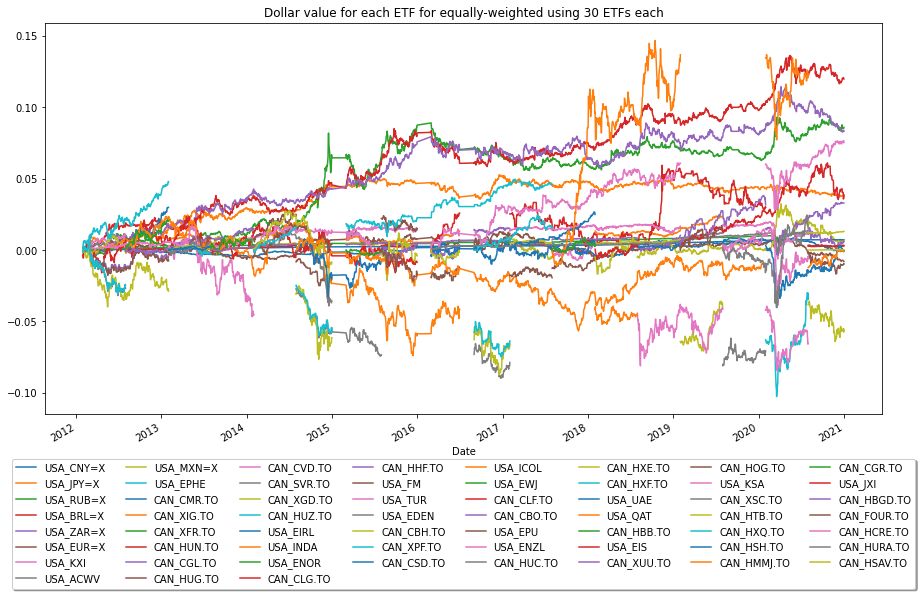

In [44]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 30 ETFs each')

# Scenario Analysis